In [1]:
import json
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask

In [26]:
# s_id = 'HT270P1-S1H1U1'
s_id = 'HT264P1-S1H2U1'

In [27]:
obj = sc.read_h5ad(f'../data/pdac/{s_id}/adata.h5ad')
obj

AnnData object with n_obs × n_vars = 3234 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [28]:
size = obj.uns['rescaled_he']['2X_trimmed'].shape[:2]
size

(7886, 7727)

In [29]:
annotations = json.load(open(f'../data/annotations/pdac/{s_id}_1X_trimmed_tumor_immune.geojson'))
annotations

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[12648, 1406],
      [12645, 1407],
      [12644, 1407],
      [12642, 1408],
      [12640, 1409],
      [12636, 1411],
      [12631, 1415],
      [12627, 1420],
      [12625, 1424],
      [12624, 1426],
      [12623, 1428],
      [12623, 1429],
      [12622, 1432],
      [12622, 1437],
      [12622, 1443],
      [12622, 1444],
      [12622, 1445],
      [12623, 1448],
      [12623, 1450],
      [12623, 1451],
      [12623.33, 1452],
      [12624, 1456],
      [12624, 1462],
      [12625.67, 1467],
      [12626, 1469],
      [12627.91, 1473.45],
      [12628, 1474],
      [12630, 1480],
      [12630, 1484],
      [12631, 1490],
      [12631, 1491],
      [12631, 1497],
      [12630.33, 1501],
      [12630, 1502],
      [12630, 1503],
      [12630, 1505],
      [12630, 1509],
      [12630, 1510],
      [12630, 1513],
      [12630, 1514],
      [12628, 1520],
      [126

In [30]:
def get_annotations_from_geojson(annotations, size, scale=2):
    feats = annotations['features']
    label_to_pts = {}
    for d in feats:
        coords = np.asarray([[r, c] for c, r in d['geometry']['coordinates'][0]]) // 2
        label = d['properties']['classification']['name']
        if label not in label_to_pts:
            label_to_pts[label] = [np.asarray(coords, dtype=np.int32)]
        else:
            label_to_pts[label].append(np.asarray(coords, dtype=np.int32))
            
    order = sorted(label_to_pts.keys())
    mask = np.zeros(size, dtype=np.int16)
    for label, ls in label_to_pts.items():
        for pts in ls:
            poly = polygon2mask(size, pts)
            mask[poly] = order.index(label) + 1
    
    return order, mask

In [31]:
labels, mask = get_annotations_from_geojson(annotations, size, scale=2)

In [32]:
obj.uns['region_annotation_labeled_img_2X_trimmed'] = mask
obj.uns['region_annotation_labels'] = labels

In [37]:
obj.write_h5ad(f'../data/pdac/{s_id}/adata.h5ad')

In [33]:
labels

['Immune cells', 'Tumor']

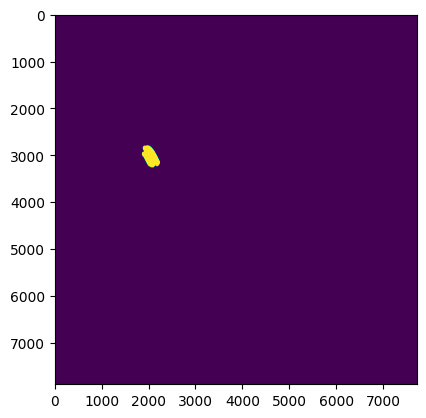

In [34]:
plt.imshow(mask==1)

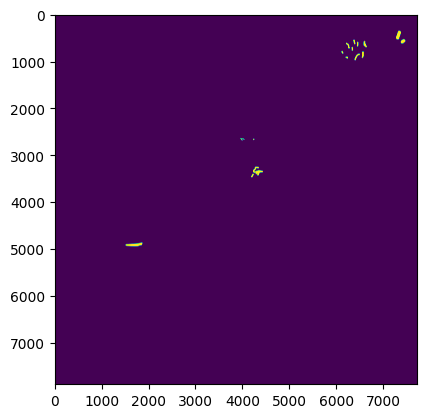

In [35]:
plt.imshow(mask==2)

In [36]:
np.unique(mask)

array([0, 1, 2], dtype=int16)